# Cross-validation lung data
Does five-fold crossvalidation in annotating lung data to get stability of different algorithms

In [1]:
import os, sys

import popv
import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
import sys
sys.path.insert(-1, '..')
import _utils

2023-02-07 17:22:34.305629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 17:22:34.512042: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 17:22:35.581576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-02-07 17:22:35.581654: W tensorflow/compiler/xla/stream_executor/platf

## Run PopV

In [2]:
refdata_url = '"https://zenodo.org/record/7587774/files/TS_Bladder_filtered.h5ad?download"'
bladder_fn = 'data/Bladder.h5ad'
if not os.path.exists(bladder_fn):
    !wget -O $bladder_fn $refdata_url

bladder = anndata.read(bladder_fn)

In [3]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [4]:
query_index = np.random.choice([0,1,2,3,4], size = len(bladder), replace=True)

In [17]:
if not os.path.exists('data'):
    os.mkdir('data')

In [18]:
for i in range(0,5):
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    bladder[query_index!=i].write(ref_adata_path)
    bladder[query_index==i].write(query_adata_path)

In [19]:
save_folder = 'popv_results'
query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [20]:
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data

In [ ]:
for i in range(0,5):
    print(i)
    save_folder = f'cv_run_{i}/popv_results_{i}'
    if not os.path.exists(f'cv_run_{i}'):
        os.mkdir(f'cv_run_{i}')
    
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    
    # read in the reference dataset
    ref_adata = anndata.read(ref_adata_path)
    query_adata = anndata.read(query_adata_path)
    
    min_celltype_size = np.min(ref_adata.obs.groupby('cell_ontology_class').size())
    n_samples_per_label = np.max((min_celltype_size, 100))
    
    adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'cv_run_{i}/pretrained_models/',
        cl_obo_folder='../PopV/ontology/',
        prediction_mode='retrain',
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata
    
    annotate_data(adata, save_path=save_folder)
    adata.write(f'cv_run_{i}/annotated_query.h5ad')

## Evaluate results

In [5]:
bladder = sc.read('data/Bladder.h5ad')

In [8]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']
query = popv.annotation.ontology_vote_onclass(query, prediction_keys=pred_keys, save_key="popv_prediction")

In [88]:
bladder.obsm['X_scanvi_umap_popv'] = query.obsm['X_scanvi_umap_popv']

In [89]:
bladder.obs['cv_prediction'] = 'na'

for k in pred_keys:
    bladder.obs[k] = 'na'
for k in ['popv_prediction_depth', 'popv_prediction_onclass_relative_depth']:
    bladder.obs[k] = 'na'

bladder.obs['cv_idx'] = 'na'

In [91]:
names = []
for i in range(5):
    print(i)
    query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
    query = popv.annotation.ontology_vote_onclass(query, prediction_keys=pred_keys, save_key="popv_prediction")
    names.append(query.obs_names)
    bladder.obs.loc[query.obs_names, 'cv_prediction'] = query.obs['popv_prediction'].astype('str')
    bladder.obs.loc[query.obs_names, 'cv_prediction_score'] = query.obs['popv_prediction_score'].astype('str')
    bladder.obs.loc[query.obs_names, 'cv_idx'] = str(i)
    for k in pred_keys:
        bladder.obs.loc[query.obs_names, k] = query.obs[k].astype('str')
    for k in ['popv_prediction_depth', 'popv_prediction_onclass_relative_depth']:
        bladder.obs.loc[query.obs_names, k] = query.obs[k].astype('str')

0
1
2
3
4


In [92]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'cv_idx', 'onclass_consensus', 'onclass_consensus_sub', 'cv_prediction_score'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'onclass_consensus_colors', 'onclass_consensus_sub_colors'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_u

... storing 'popv_onclass_prediction_sub' as categorical


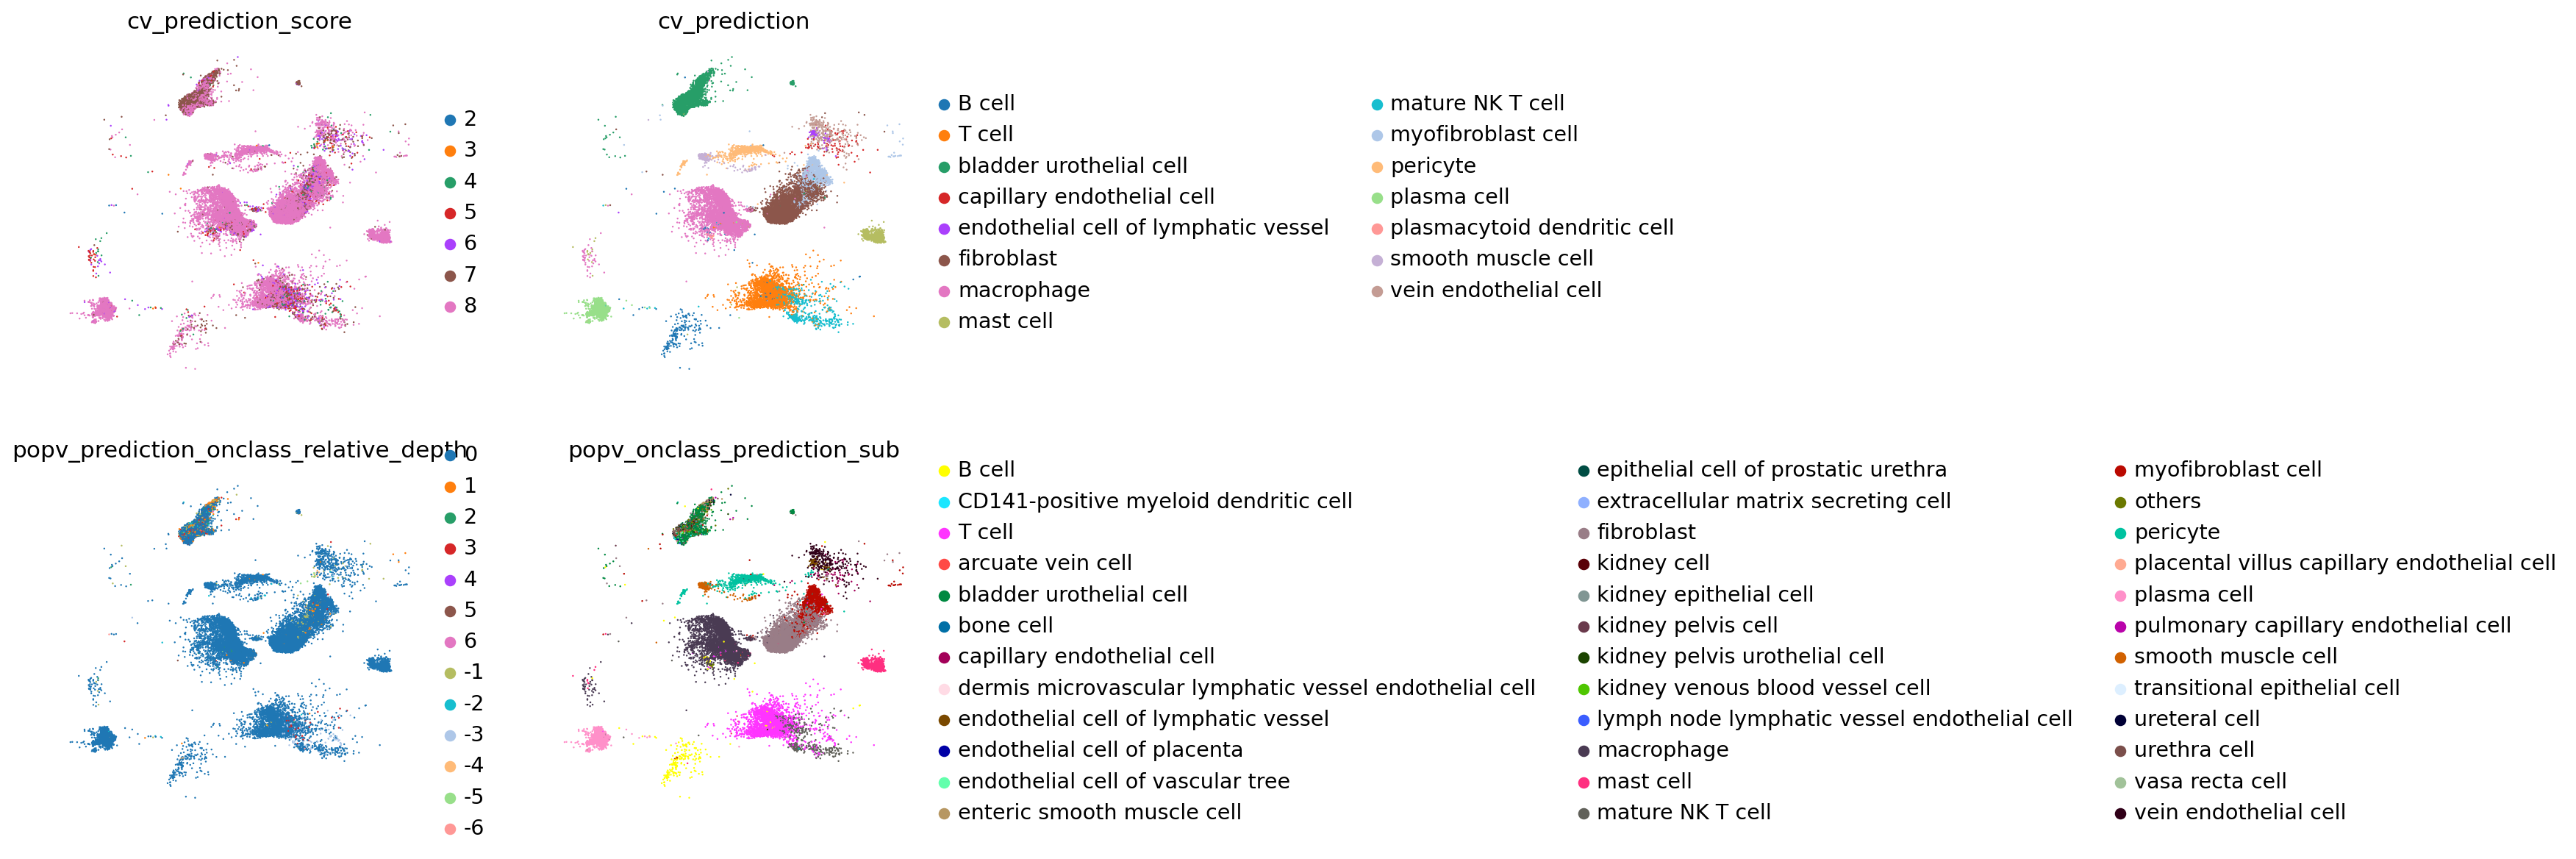

KeyError: 'popv_prediction'

In [94]:
bladder.obs['popv_onclass_prediction_sub'] = bladder.obs['popv_onclass_prediction'].astype(str)
bladder.obs.loc[bladder.obs_names[bladder.obs["popv_onclass_prediction"].isin(
                    bladder.obs["popv_onclass_prediction"].value_counts()[
                        bladder.obs[
                            "popv_onclass_prediction"].value_counts() < 20].keys()
                    )], 'popv_onclass_prediction_sub'] = 'others'
sc.pl.umap(
    bladder,
    color=['cv_prediction_score', 'cv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub'],
    ncols=2, save='onclass_all_cells.png', frameon=False)

urothelial = bladder[bladder.obs['popv_prediction']=='bladder urothelial cell']

sc.pl.umap(
    urothelial,
    color=['cv_prediction_score', 'popv_prediction', 'popv_prediction_onclass_relative_depth', 'popv_onclass_prediction_sub'],
    ncols=2, save='onclass_epithelial_cells.png', frameon=False)

Making confusion matrix for popv_celltypist_prediction


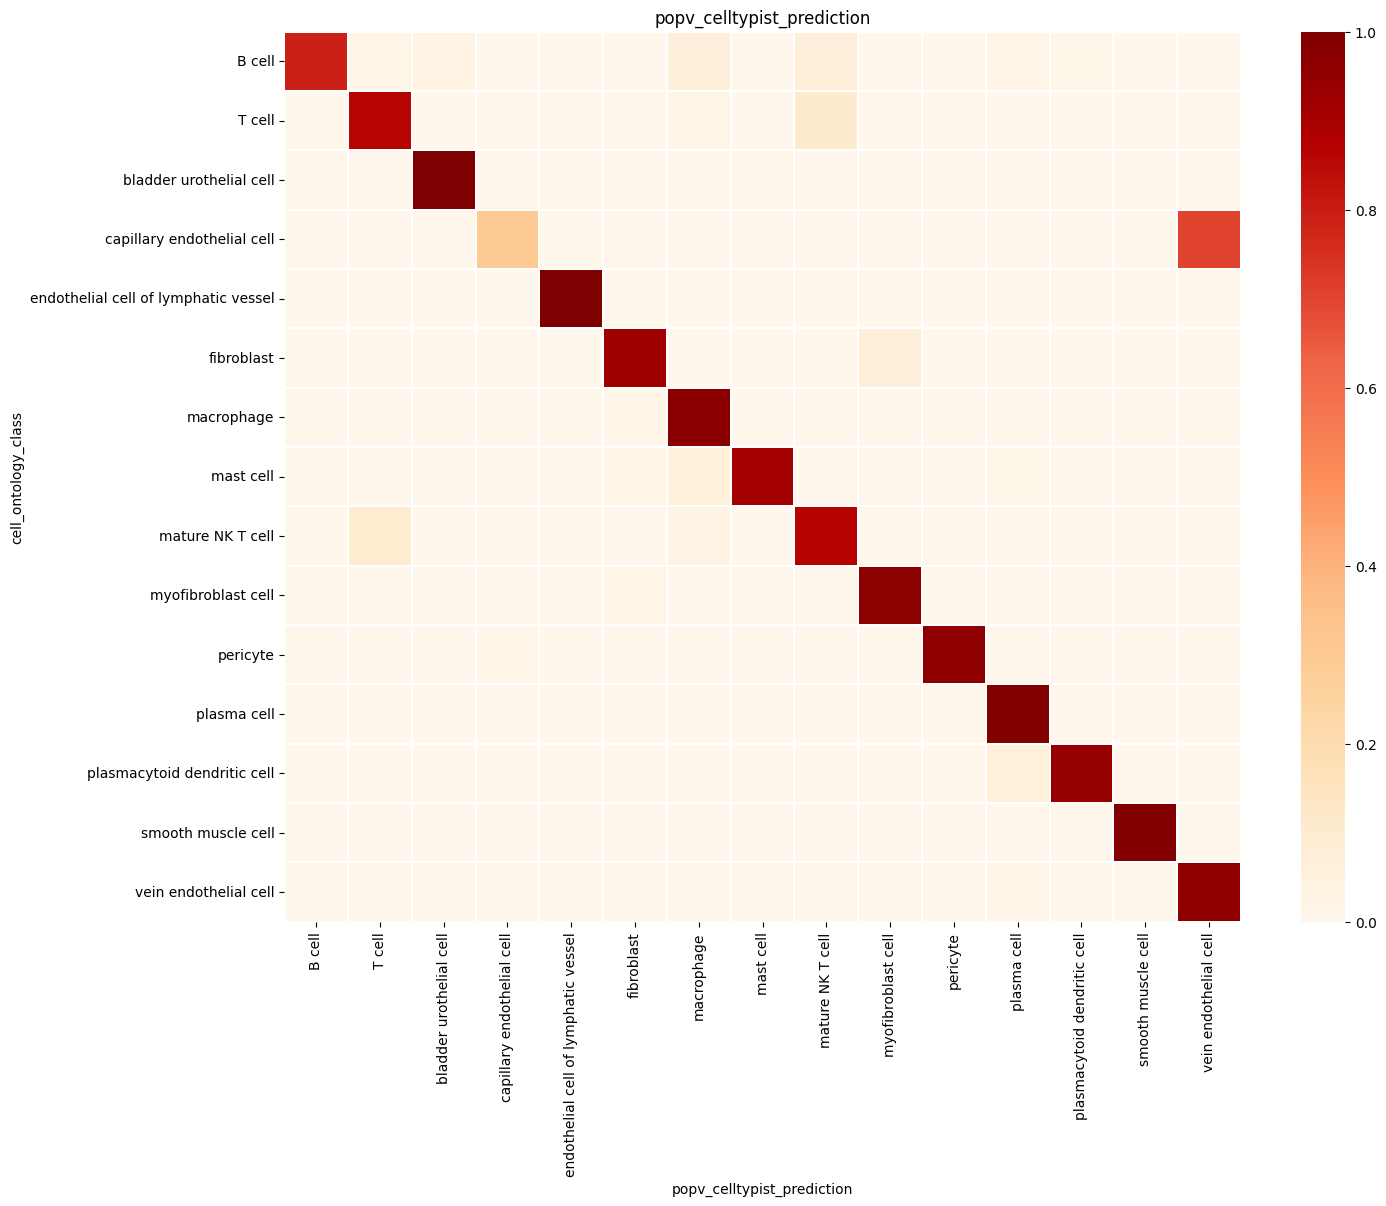

Making confusion matrix for popv_knn_on_bbknn_prediction


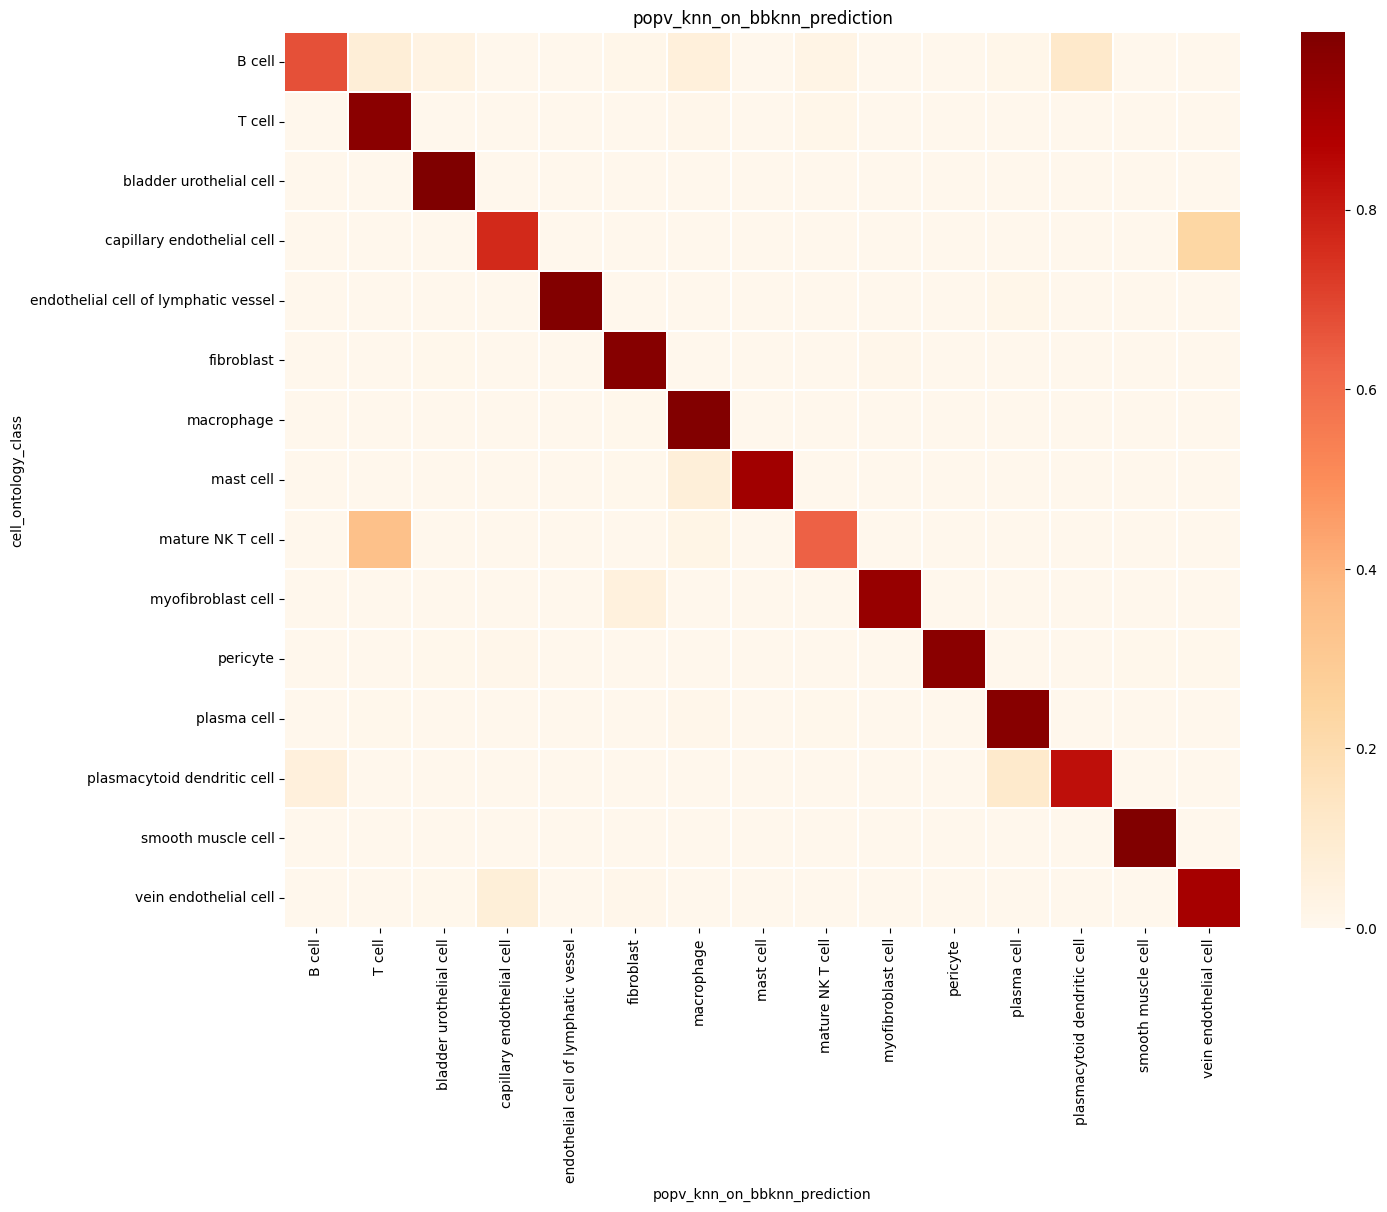

Making confusion matrix for popv_knn_on_scanorama_prediction


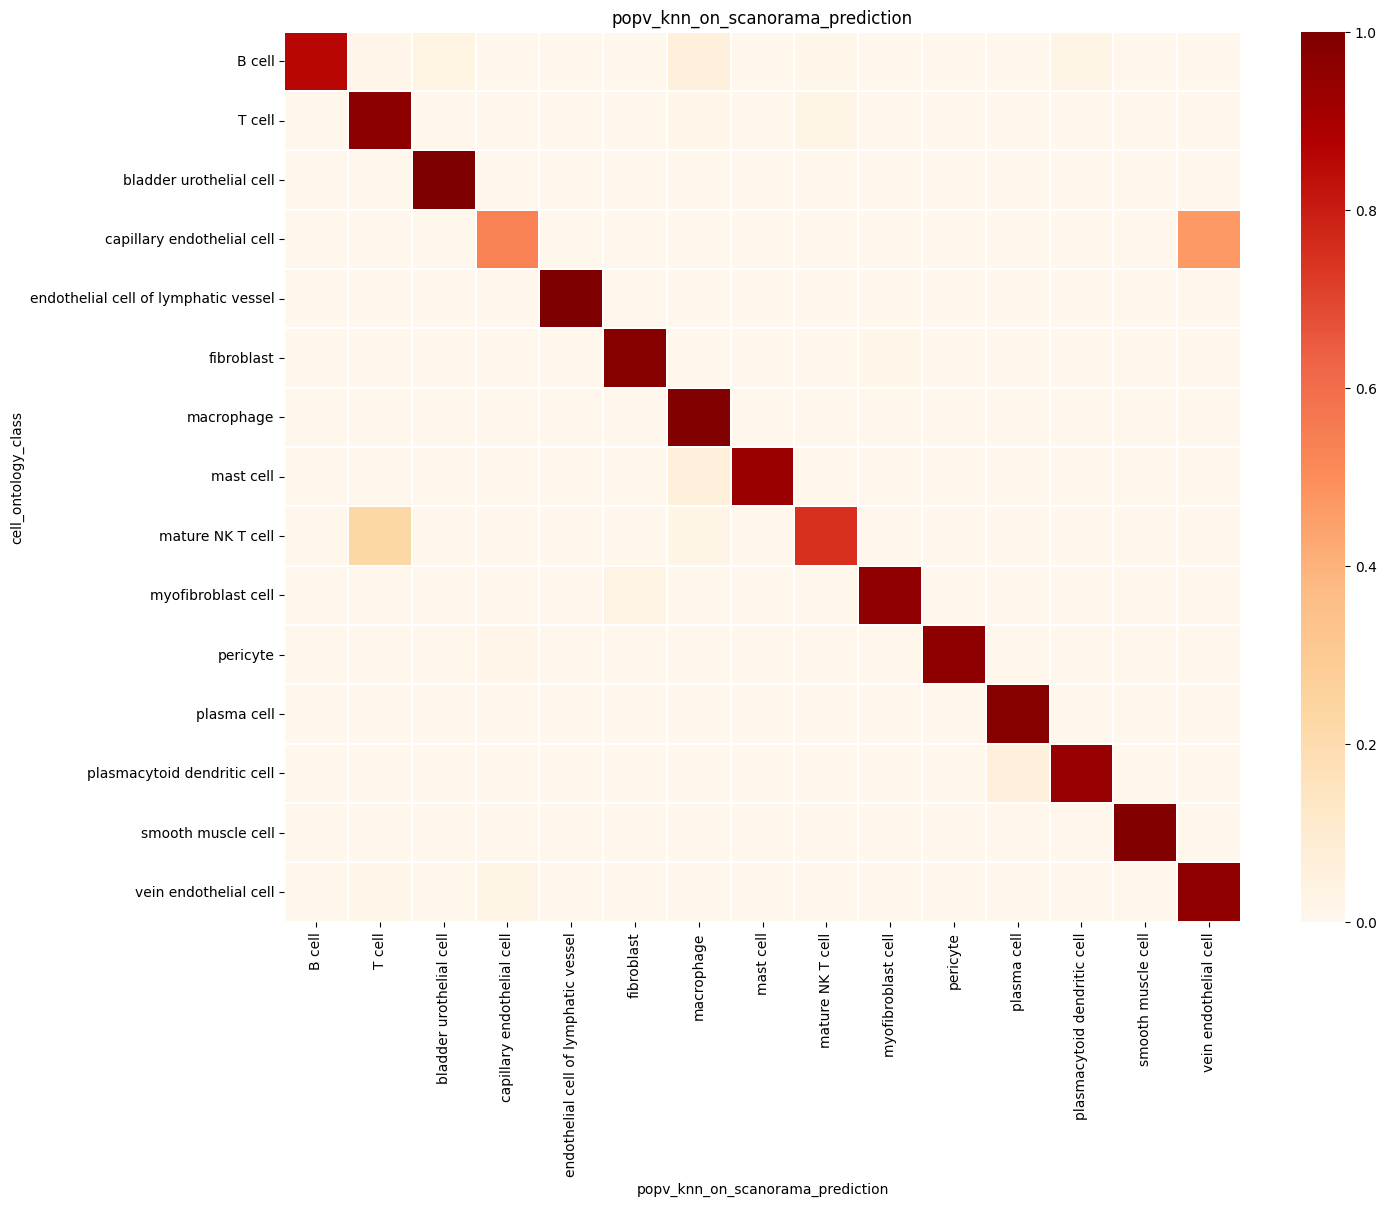

Making confusion matrix for popv_knn_on_scvi_prediction


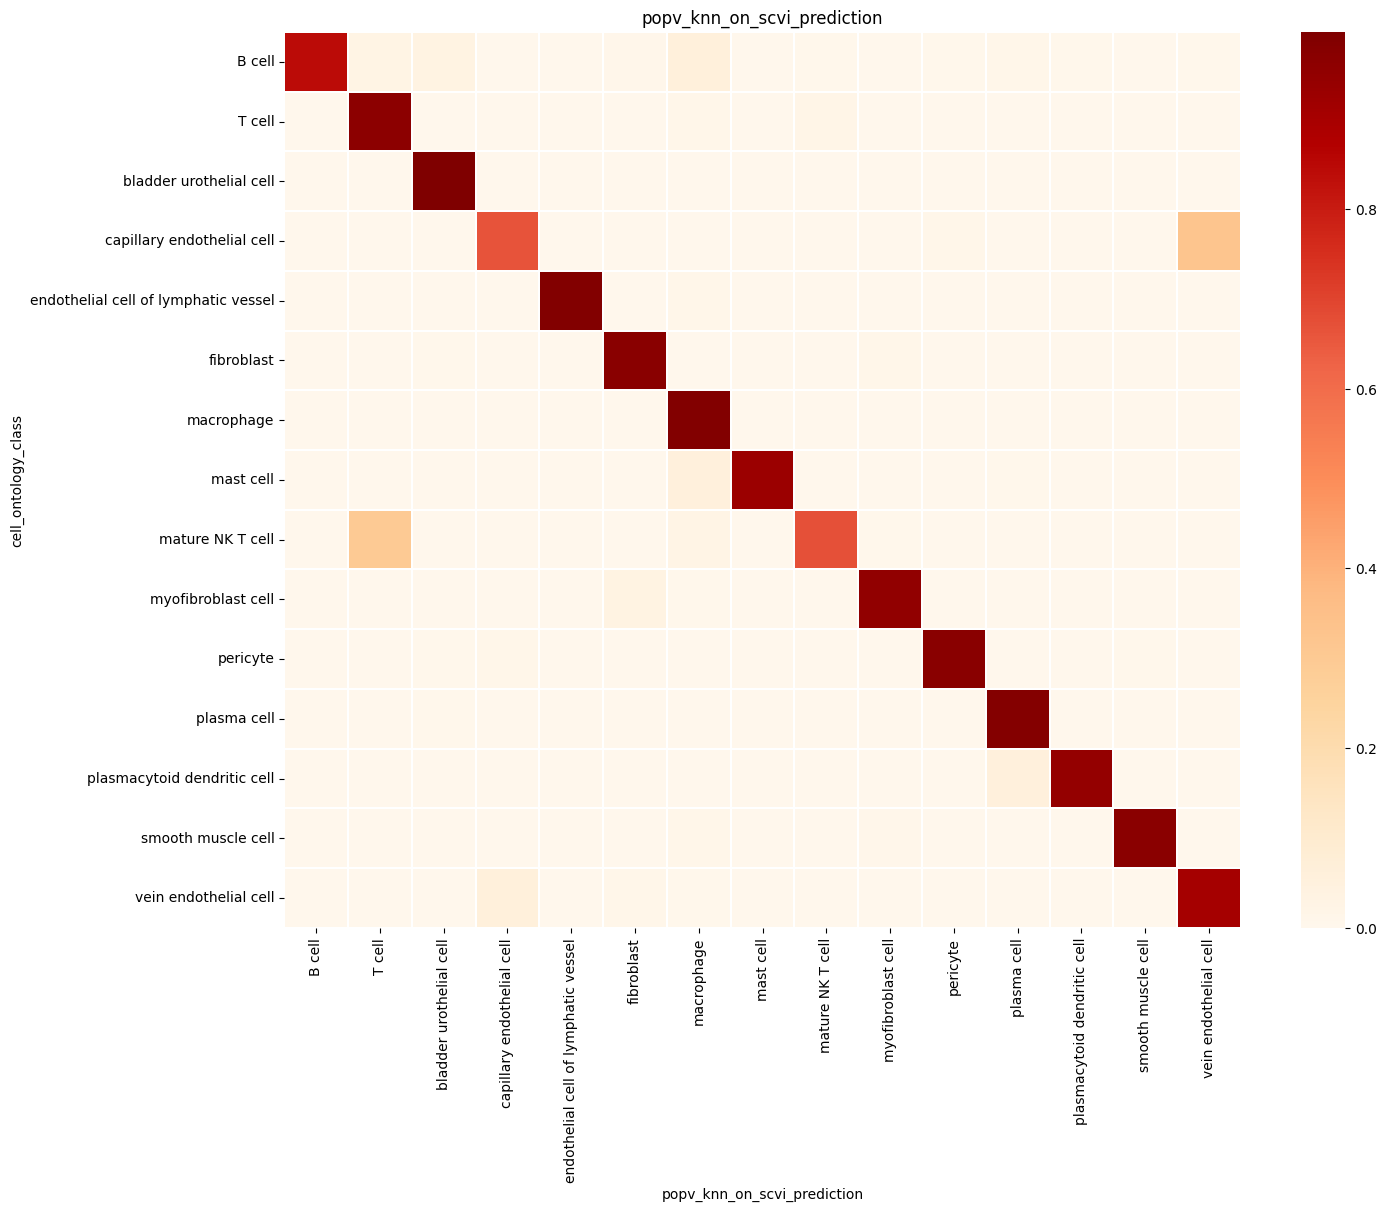

Making confusion matrix for popv_onclass_prediction


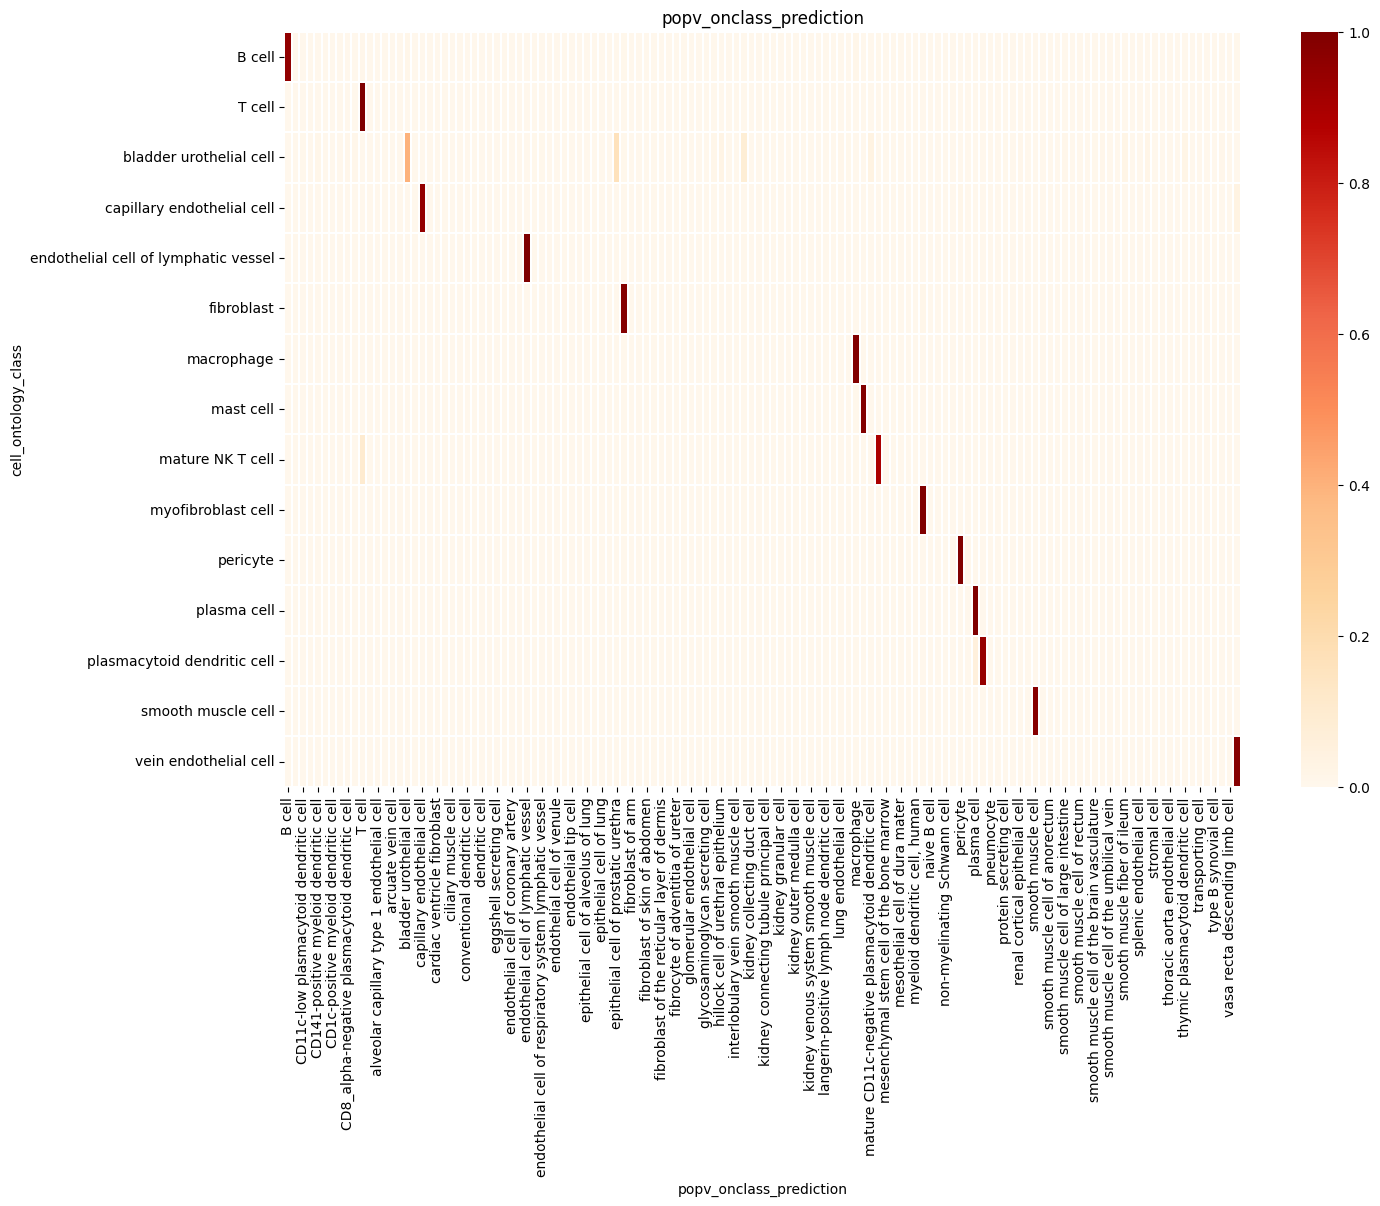

Making confusion matrix for popv_rf_prediction


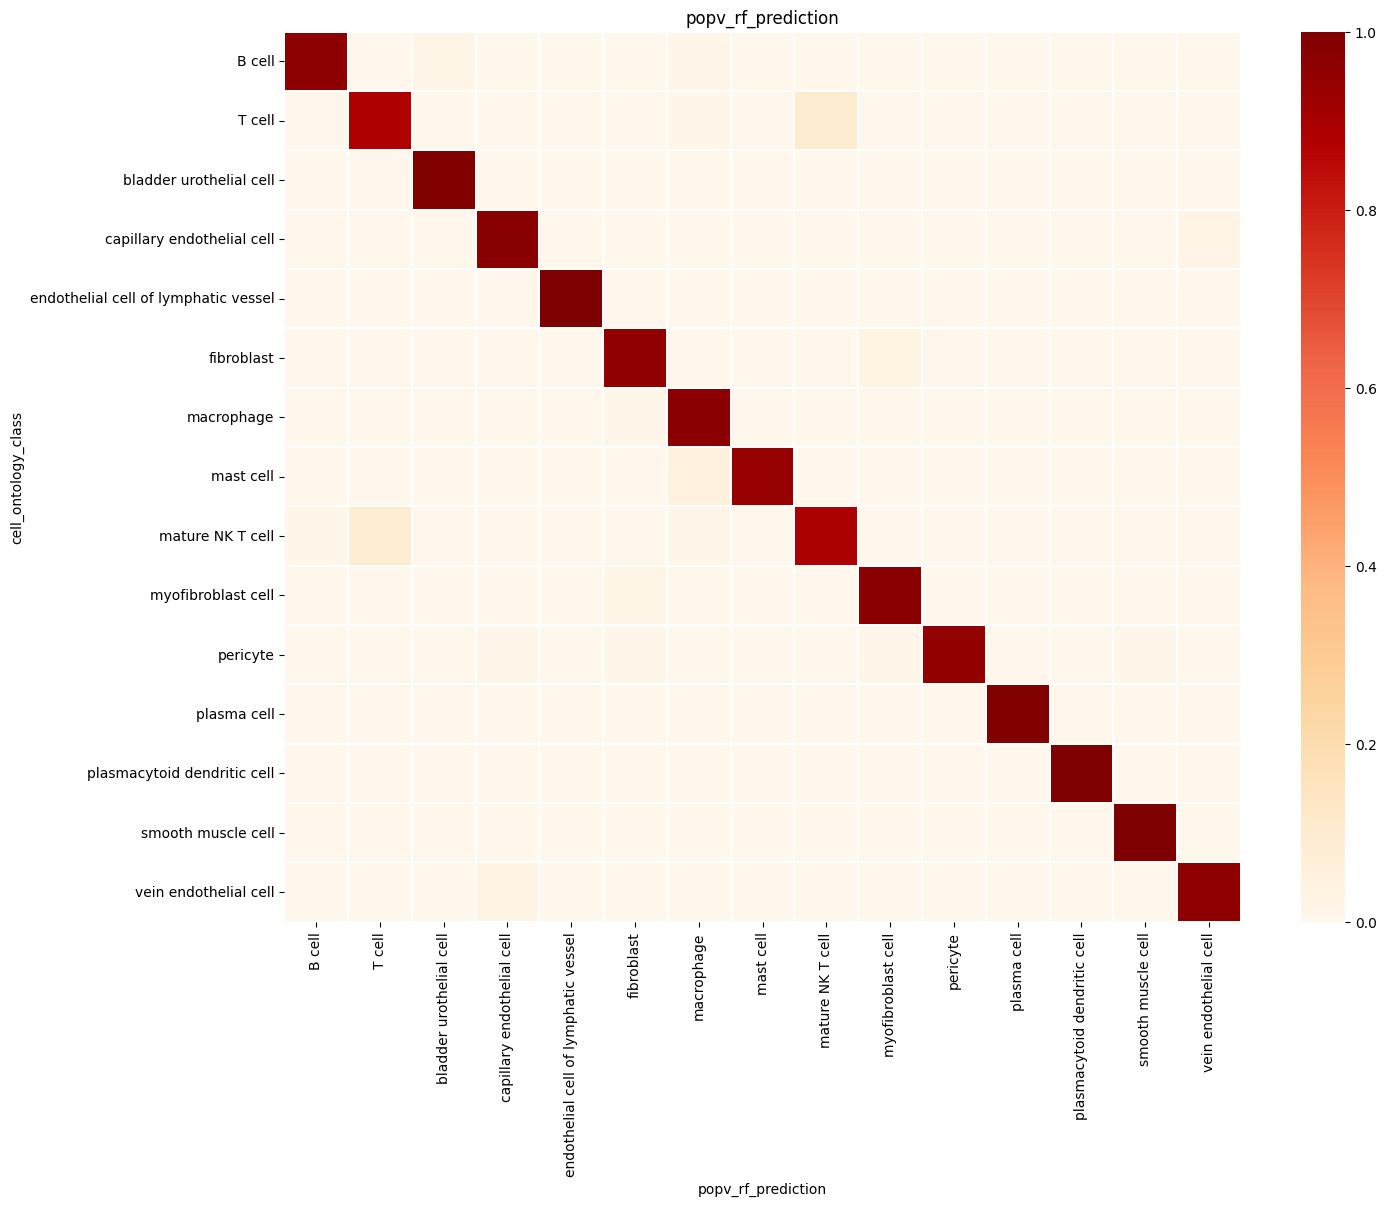

Making confusion matrix for popv_scanvi_prediction


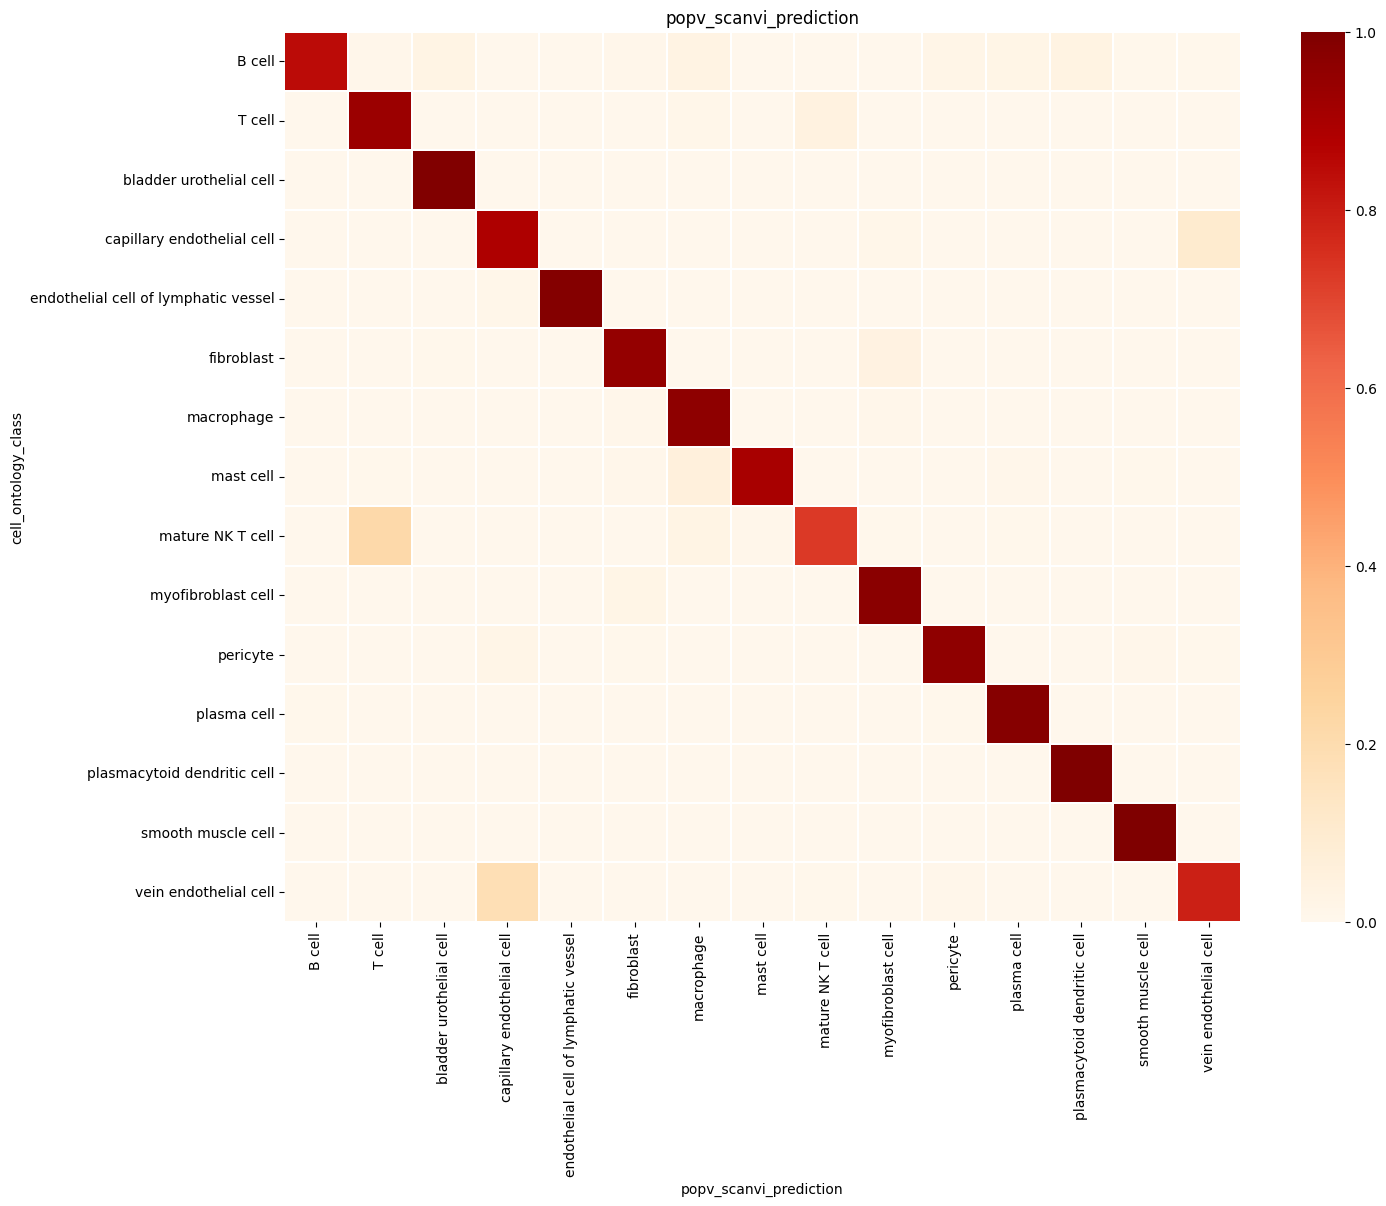

Making confusion matrix for popv_svm_prediction


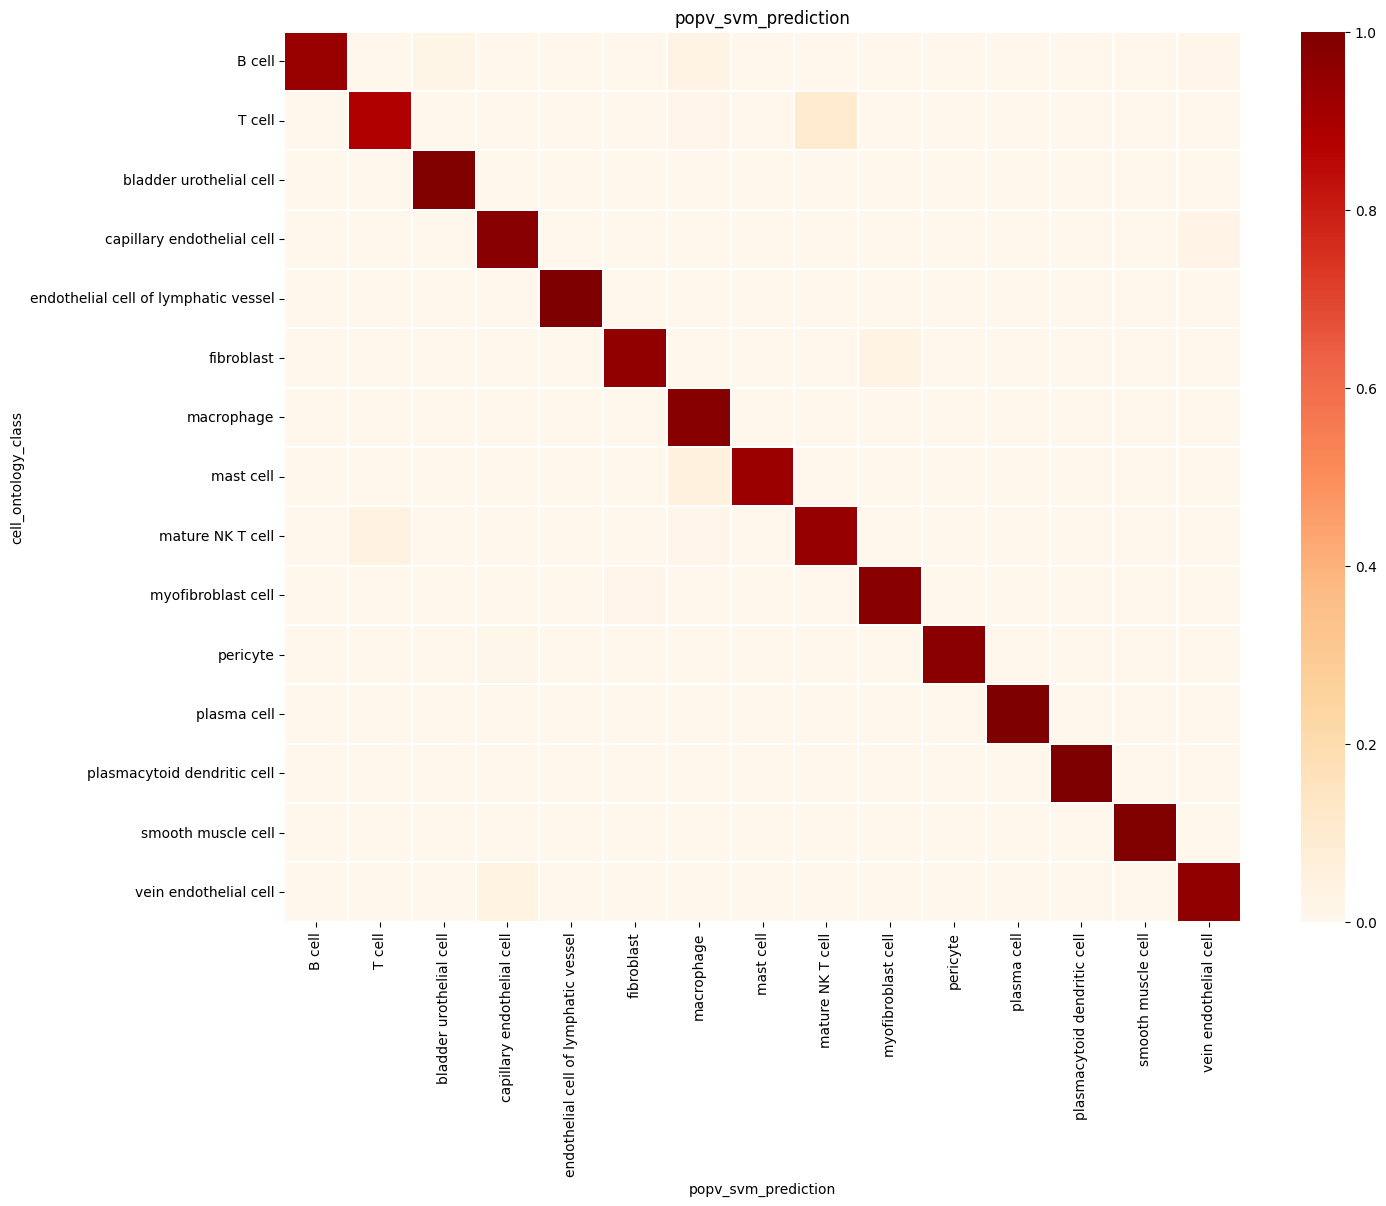

In [ ]:
popv.visualization.make_agreement_plots(
    query, prediction_keys=query.uns['prediction_keys'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [ ]:
popv.visualization.make_agreement_plots(bladder, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

Making confusion matrix for cv_prediction


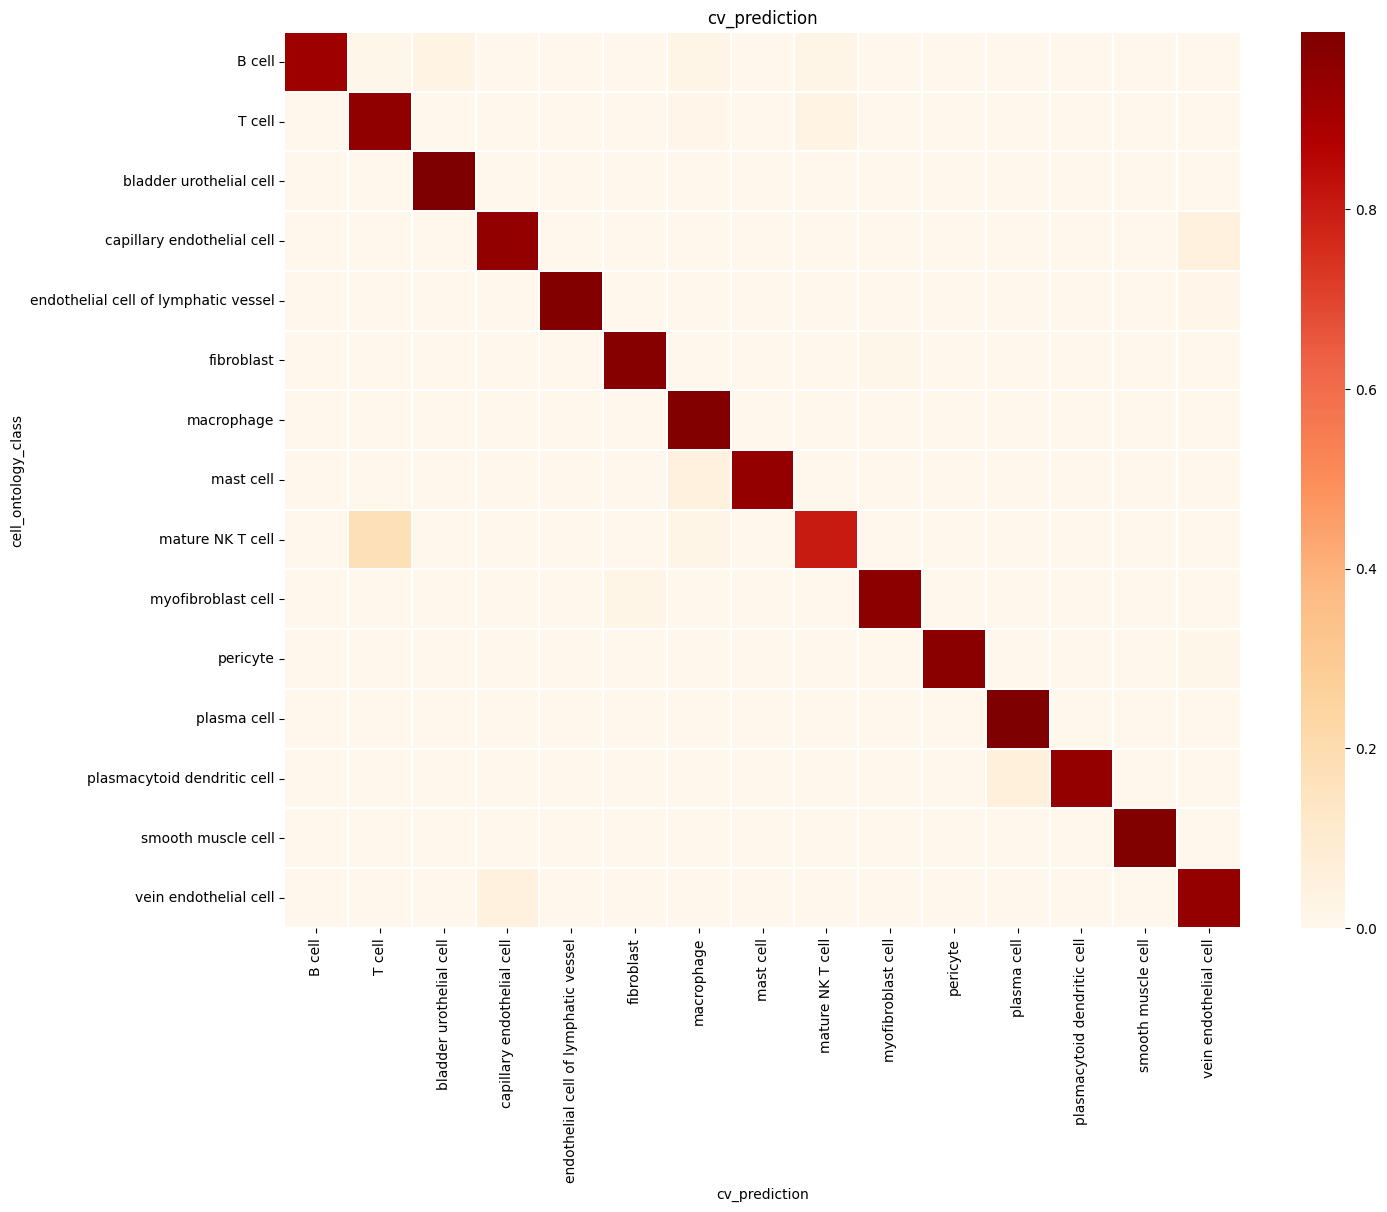

In [31]:
popv.visualization.make_agreement_plots(bladder, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [36]:
bladder.write('data/Bladder_cv_results_.h5ad')

## Weight matrix

In [37]:
from popv.reproducibility import _accuracy
import pandas as pd

In [38]:
bladder = sc.read('data/Bladder_cv_results_.h5ad')

In [39]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = query.uns['prediction_keys']

In [40]:
for key in pred_keys:
    _accuracy._absolute_accuracy(bladder, key, 'cell_ontology_class', save_key=key + '_abs_accuracy' )

In [41]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'cv_idx', 'popv_celltypist_prediction_abs_accuracy', 'popv_knn_on_bbknn_prediction_abs_accuracy', 'popv_knn_on_scanorama_prediction_abs_accuracy', 'popv_knn_on_scvi_prediction_abs_accuracy', 'popv_onclass_prediction_abs_accuracy', 'popv_rf_prediction_abs_accuracy', 'popv_scanvi_prediction_abs_accuracy', 'popv_svm_prediction_abs_accuracy'
    var: 'feature_type', 'ensemblid', 'highly_va

In [42]:
pred_acc_keys = [k + "_abs_accuracy" for k in pred_keys]

In [43]:
weight_matrix = pd.DataFrame(index=np.unique(bladder.obs[pred_keys]))

In [44]:
for pred_key, acc_key in zip(pred_keys, pred_acc_keys):
    weight_matrix[pred_key] = bladder.obs.groupby(pred_key).mean()[acc_key]

In [45]:
weight_matrix.head()

,popv_celltypist_prediction,popv_knn_on_bbknn_prediction,popv_knn_on_scanorama_prediction,popv_knn_on_scvi_prediction,popv_onclass_prediction,popv_rf_prediction,popv_scanvi_prediction,popv_svm_prediction
B cell,0.768116,0.924855,0.977064,0.981132,0.995833,0.672131,0.937778,0.790164
B cell of anorectum,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
B cell of appendix,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
B cell of medullary sinus of lymph node,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
"B cell, CD19-positive",NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


In [47]:
weight_matrix = weight_matrix.replace(np.nan, 0)
weight_matrix = weight_matrix.replace(0, 1/len(np.unique(bladder.obs[pred_keys])))

In [ ]:
sc.pl.umap(bladder, color='popv_prediction_onclass_relative_depth')

In [48]:
bladder

AnnData object with n_obs × n_vars = 24583 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', 'cv_prediction', 'popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'cv_idx', 'popv_celltypist_prediction_abs_accuracy', 'popv_knn_on_bbknn_prediction_abs_accuracy', 'popv_knn_on_scanorama_prediction_abs_accuracy', 'popv_knn_on_scvi_prediction_abs_accuracy', 'popv_onclass_prediction_abs_accuracy', 'popv_rf_prediction_abs_accuracy', 'popv_scanvi_prediction_abs_accuracy', 'popv_svm_prediction_abs_accuracy'
    var: 'feature_type', 'ensemblid', 'highly_va

In [ ]:
weight_matrix.to_csv('lung_weights.csv')

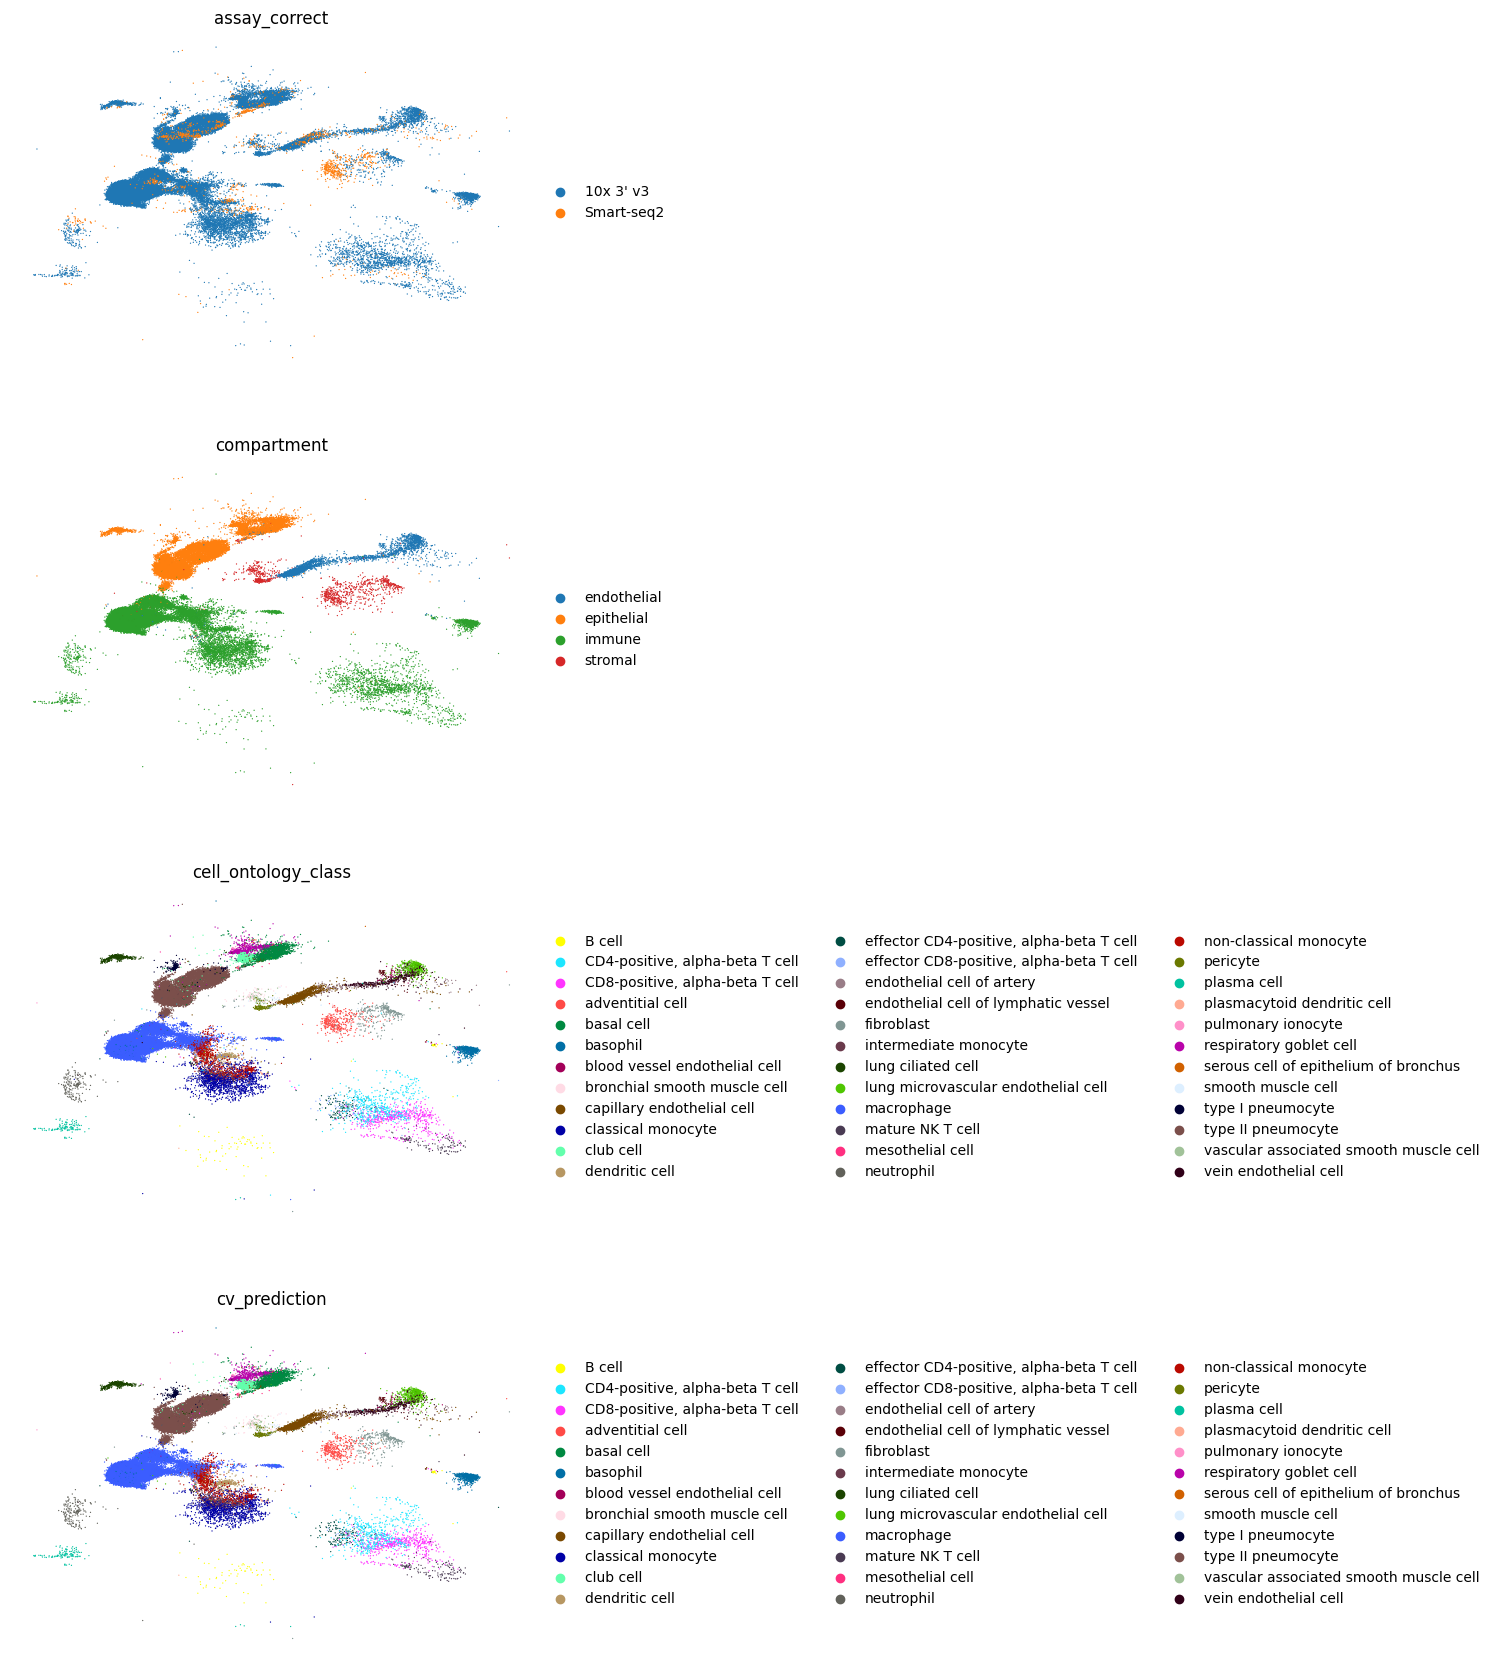

In [ ]:
sc.pl.umap(lung, color=['assay_correct', 'compartment', 'cell_ontology_class', 'cv_prediction'], ncols=1, frameon=False)